In [4]:
from os import listdir, path, getcwd
from zipfile import ZipFile


source_dir_abs = getcwd()

extracted_dir = path.join(source_dir_abs, "extracted")

for file in listdir(path.join(source_dir_abs, "raw_zip_rain")):
    with ZipFile(path.join(source_dir_abs, "raw_zip_rain",file), 'r') as zip:
        zip.extractall(extracted_dir)


In [5]:
import pandas as pd

abs_dir = path.join(source_dir_abs, "extracted")

merged = pd.DataFrame()

for file in listdir(abs_dir):
    file_path = path.join(source_dir_abs, "extracted", file)
    single_df = pd.read_csv(file_path, encoding="latin",header=None)
    merged = pd.concat(objs=[merged,single_df],axis=0)

AttributeError: partially initialized module 'pandas' has no attribute '_pandas_parser_CAPI' (most likely due to a circular import)

In [ ]:
# df = merged[[0,1,2,3,4]]
# df

df = merged.iloc[:,:5]
df = df.rename(columns={0:"id_stacji",1:"nazwa_stacji",2:"rok",3:"msc",4:"opad"})


In [ ]:
df

,id_stacji,nazwa_stacji,rok,msc,opad
0,249180020,WARSZOWICE,2001,1,54.1
1,249180020,WARSZOWICE,2001,2,31.0
2,249180020,WARSZOWICE,2001,3,47.8
3,249180020,WARSZOWICE,2001,4,102.7
4,249180020,WARSZOWICE,2001,5,51.9
...,...,...,...,...,...
6916,254230020,SEJNY,2022,8,40.5
6917,254230020,SEJNY,2022,9,35.0
6918,254230020,SEJNY,2022,10,25.5
6919,254230020,SEJNY,2022,11,29.6


In [ ]:
%pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# %pip install pandas
# %pip install statsmodels
# %pip install matplotlib
# %pip install scikit-learn
# %pip install numpy


In [ ]:
import pandas as pd
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import itertools

# Wczytanie danych
abs_dir = os.path.join(source_dir_abs, "extracted")
merged = pd.DataFrame()

for file in os.listdir(abs_dir):
    file_path = os.path.join(source_dir_abs, "extracted", file)
    single_df = pd.read_csv(file_path, encoding="latin", header=None)
    merged = pd.concat(objs=[merged, single_df], axis=0)

df = merged.iloc[:, :5]
df = df.rename(columns={0: "id_stacji", 1: "nazwa_stacji", 2: "rok", 3: "msc", 4: "opad"})

# Konwersja na serię czasową
df['data'] = pd.to_datetime(df['rok'].astype(str) + '-' + df['msc'].astype(str))
df.set_index('data', inplace=True)

# Ograniczenie do trzech wybranych stacji
wybrane_stacje = ['WARSZOWICE', 'HARKABUZ', 'RAJCZA'] 

# Prognozowanie dla wybranych stacji
for nazwa_stacji in wybrane_stacje:
    station_data = df[df['nazwa_stacji'] == nazwa_stacji]
    
    if station_data.empty:
        continue  # Pomiń, jeśli brak danych dla stacji
    
    # Miesięczne sumowanie opadów
    monthly_data = station_data['opad'].resample('M').sum()
    
    # Podział na dane treningowe i testowe
    train = monthly_data.iloc[:-12]  # Ostatnie 12 miesięcy na dane testowe
    test = monthly_data.iloc[-12:]
    
    # Stosowanie uproszczonego modelu SARIMA (można dostosować)
    mod = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results = mod.fit()

    # Prognozowanie
    pred = results.get_forecast(steps=12)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    y_truth = test

    # Obliczanie MSE i RMSE
    mse = mean_squared_error(y_truth, y_forecasted)
    rmse = sqrt(mse)

    # Wyświetlanie wyników w formie tabeli
    forecasted_data = pd.DataFrame({'Miesiąc': y_forecasted.index.month, 'Prognozowany opad': y_forecasted.values})
    print(f'Wyniki dla stacji: {nazwa_stacji}')
    print(forecasted_data.to_string(index=False))
    print(f'RMSE: {rmse}\n')


C:\Users\Acer\AppData\Local\Temp\ipykernel_11116\3691948235.py:35: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = station_data['opad'].resample('M').sum()


Wyniki dla stacji: WARSZOWICE
 Miesiąc  Prognozowany opad
       1          53.433886
       2          42.770038
       3          45.717881
       4          40.741204
       5          86.807388
       6          97.043258
       7         103.066548
       8          75.490803
       9          68.641484
      10          59.445557
      11          50.702506
      12          44.586503
RMSE: 28.527682368754952



C:\Users\Acer\AppData\Local\Temp\ipykernel_11116\3691948235.py:35: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = station_data['opad'].resample('M').sum()


Wyniki dla stacji: HARKABUZ
 Miesiąc  Prognozowany opad
       1          45.938546
       2          49.921165
       3          50.417451
       4          55.930819
       5         112.604482
       6          98.335053
       7         128.274444
       8         121.872621
       9          84.353332
      10          65.951757
      11          48.927809
      12          43.560454
RMSE: 40.62079841353936



C:\Users\Acer\AppData\Local\Temp\ipykernel_11116\3691948235.py:35: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = station_data['opad'].resample('M').sum()


Wyniki dla stacji: RAJCZA
 Miesiąc  Prognozowany opad
       1          68.128197
       2          58.099871
       3          58.151555
       4          56.546467
       5         122.790527
       6         112.001538
       7         121.686716
       8          97.680544
       9          94.522290
      10          79.678576
      11          62.410639
      12          58.477943
RMSE: 31.605111005003728



## 


In [ ]:
import pandas as pd
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import itertools

# Wczytanie danych
abs_dir = os.path.join(source_dir_abs, "extracted")
merged = pd.DataFrame()

for file in os.listdir(abs_dir):
    file_path = os.path.join(source_dir_abs, "extracted", file)
    single_df = pd.read_csv(file_path, encoding="latin", header=None)
    merged = pd.concat(objs=[merged, single_df], axis=0)

df = merged.iloc[:, :5]
df = df.rename(columns={0: "id_stacji", 1: "nazwa_stacji", 2: "rok", 3: "msc", 4: "opad"})

# Konwersja na serię czasową
df['data'] = pd.to_datetime(df['rok'].astype(str) + '-' + df['msc'].astype(str))
df.set_index('data', inplace=True)

# Ograniczenie do trzech wybranych stacji
wybrane_stacje = ['WARSZOWICE', 'HARKABUZ', 'RAJCZA'] 

# Prognozowanie dla wybranych stacji
for nazwa_stacji in wybrane_stacje:
    station_data = df[df['nazwa_stacji'] == nazwa_stacji]
    
    if station_data.empty:
        continue  # Pomiń, jeśli brak danych dla stacji
    
    # Miesięczne sumowanie opadów
    monthly_data = station_data['opad'].resample('M').sum()
    
    # Podział na dane treningowe i testowe
    train = monthly_data.iloc[:-12]  # Ostatnie 12 miesięcy na dane testowe
    test = monthly_data.iloc[-12:]
    
    # Stosowanie uproszczonego modelu SARIMA (można dostosować)
    mod = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    results = mod.fit()

    # Prognozowanie
    pred = results.get_forecast(steps=12)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    y_truth = test

    # Obliczanie MSE i RMSE
    mse = mean_squared_error(y_truth, y_forecasted)
    rmse = sqrt(mse)


    # Wyświetlanie wyników prognozy
    forecasted_data = pd.DataFrame({'Miesiąc': y_forecasted.index.month, 'Prognozowany opad': y_forecasted.values})
    print('Prognozowane opady:')
    print(forecasted_data.to_string(index=False))
    print(f'RMSE: {rmse}\n')


C:\Users\Acer\AppData\Local\Temp\ipykernel_11116\2657736657.py:35: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = station_data['opad'].resample('M').sum()


Prognozowane opady:
 Miesiąc  Prognozowany opad
       1          53.433886
       2          42.770038
       3          45.717881
       4          40.741204
       5          86.807388
       6          97.043258
       7         103.066548
       8          75.490803
       9          68.641484
      10          59.445557
      11          50.702506
      12          44.586503
RMSE: 28.527682368754952



C:\Users\Acer\AppData\Local\Temp\ipykernel_11116\2657736657.py:35: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = station_data['opad'].resample('M').sum()


Prognozowane opady:
 Miesiąc  Prognozowany opad
       1          45.938546
       2          49.921165
       3          50.417451
       4          55.930819
       5         112.604482
       6          98.335053
       7         128.274444
       8         121.872621
       9          84.353332
      10          65.951757
      11          48.927809
      12          43.560454
RMSE: 40.62079841353936



C:\Users\Acer\AppData\Local\Temp\ipykernel_11116\2657736657.py:35: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = station_data['opad'].resample('M').sum()


Prognozowane opady:
 Miesiąc  Prognozowany opad
       1          68.128197
       2          58.099871
       3          58.151555
       4          56.546467
       5         122.790527
       6         112.001538
       7         121.686716
       8          97.680544
       9          94.522290
      10          79.678576
      11          62.410639
      12          58.477943
RMSE: 31.605111005003728



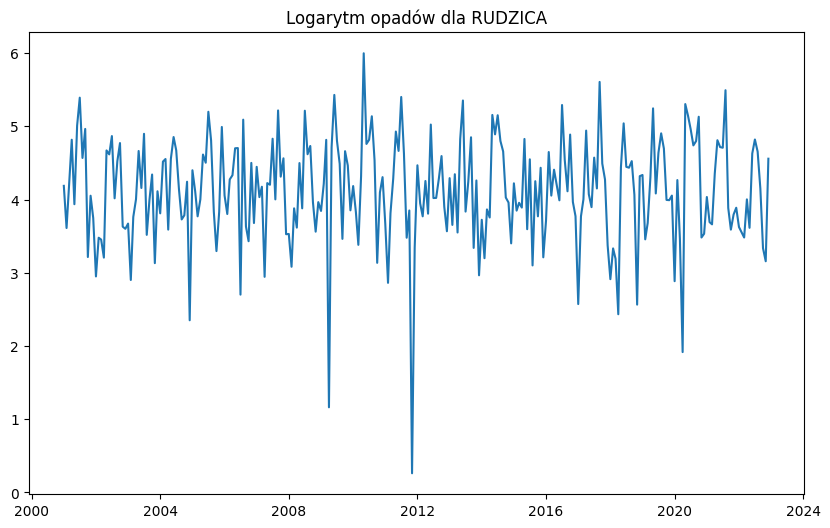

ADF Statistic: -10.769115
p-value: 0.000000
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=668.240, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=597.353, Time=0.24 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=666.322, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=669.938, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=573.519, Time=1.02 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=562.439, Time=1.94 sec
 ARIMA(1,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=5.95 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=3.22 sec
 ARIMA(0,0,0)(3,1,0)[12] intercept   : AIC=560.920, Time=1.77 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=572.098, Time=1.10 sec
 ARIMA(0,0,0)(3,1,1)[12] intercept   : AIC=inf, Time=6.27 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=2.35 sec
 ARIMA(0,0,1)(3,1,0)[12] intercept   : AIC=562.367, Time=1.89 sec
 ARIMA(1,

C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=58.731729910893314, expected=83.29999999999998
predicted=105.52858660826257, expected=91.19999999999999
predicted=70.62678469510102, expected=57.20000000000001
predicted=64.0483110663782, expected=12.0
predicted=29.804582095138187, expected=74.10000000000002
predicted=27.853729098748783, expected=75.29999999999997
predicted=49.5362592318367, expected=30.699999999999996
predicted=43.652312146635154, expected=38.599999999999994
predicted=48.20895815730726, expected=73.00000000000003
predicted=79.33514240519648, expected=188.49999999999997
predicted=60.91661698043762, expected=58.300000000000004
predicted=112.24698602019684, expected=102.29999999999998
predicted=56.71031347114768, expected=133.70000000000005
predicted=97.44935458328891, expected=108.5
predicted=73.90228858976405, expected=53.3
predicted=43.68962294442055, expected=53.09999999999999
predicted=38.526644744124866, expected=56.6
predicted=28.201599113770147, expected=16.899999999999995


C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=44.00129340845756, expected=70.19999999999999
predicted=41.557428554893306, expected=30.900000000000002
predicted=57.882713121677256, expected=5.800000000000001
predicted=87.26477988869988, expected=199.90000000000003
predicted=70.94050369974855, expected=170.50000000000006
predicted=111.17816181500066, expected=141.80000000000007
predicted=89.33534553660044, expected=113.30000000000004
predicted=112.22279102330813, expected=120.3
predicted=75.95477645479669, expected=168.0
predicted=37.77992564514791, expected=31.5
predicted=48.234862019763256, expected=33.20000000000001
predicted=24.022140268456962, expected=55.50000000000001
predicted=39.0750084610188, expected=39.099999999999994
predicted=35.081758032432944, expected=37.89999999999999
predicted=30.21208580987617, expected=76.69999999999997
predicted=117.82527687845496, expected=121.69999999999996
predicted=88.05557311233194, expected=110.7
predicted=103.4592100178768, expected=109.7
predicted=95.61400365548106, expected=2

C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=31.595997367377834, expected=36.5
predicted=40.56697382221051, expected=33.8
predicted=31.881953463097886, expected=31.5
predicted=22.10755523643298, expected=53.69999999999998
predicted=144.11257149782685, expected=36.1


C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=116.07583494672906, expected=101.30000000000003
predicted=109.11582281511119, expected=122.89999999999995
predicted=130.7554011054764, expected=103.99999999999997


C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=88.87810733010589, expected=62.30000000000002
predicted=68.65116945073045, expected=27.099999999999998
predicted=30.85410103927171, expected=22.500000000000004
predicted=50.084649763751, expected=94.30000000000004
Test RMSE: 47.01757357664378


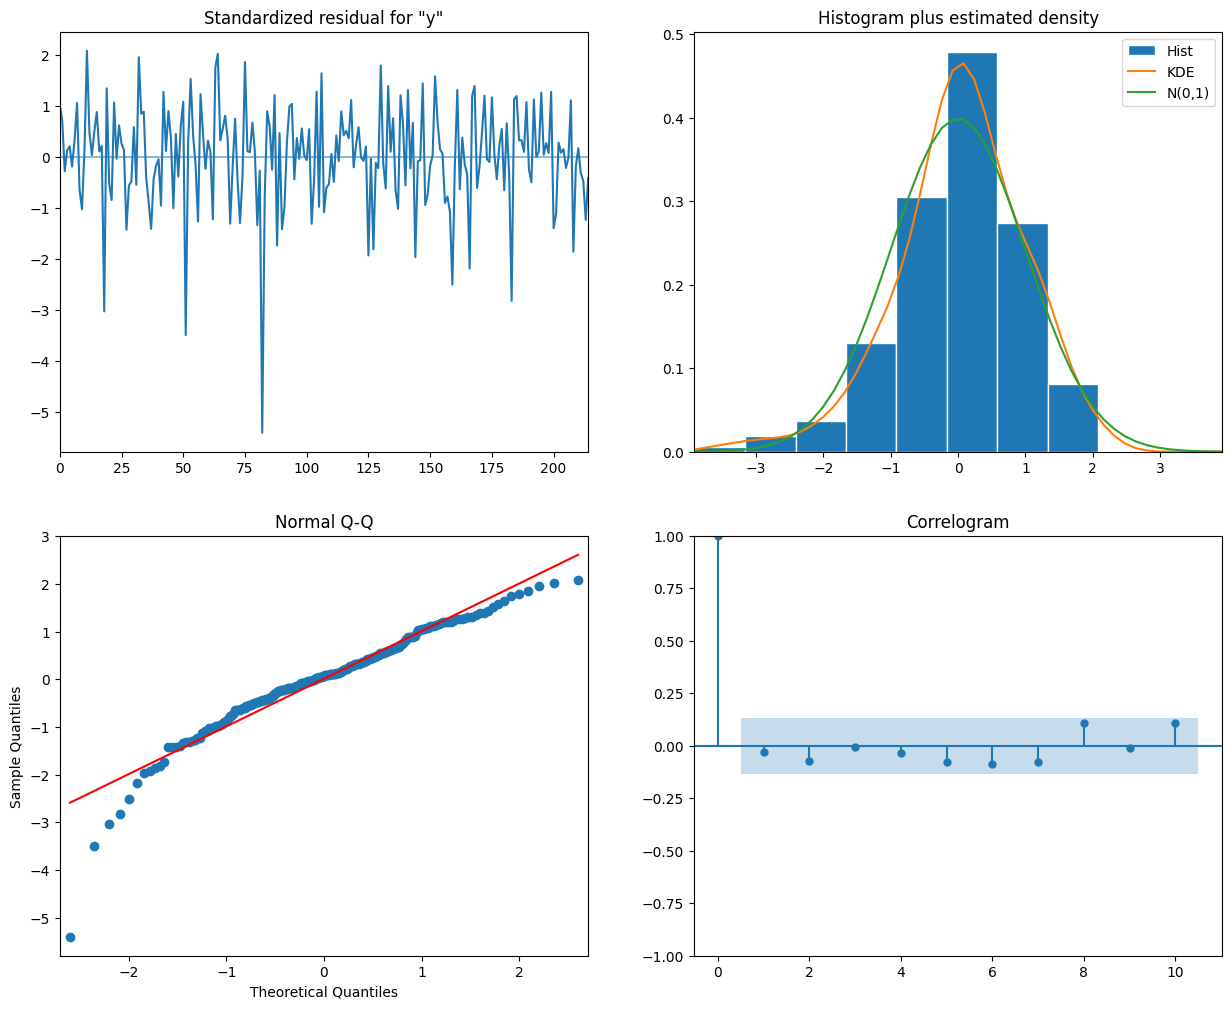

In [7]:
import pandas as pd
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot as plt
from pmdarima import auto_arima
import numpy as np


# Wczytanie i połączenie danych
abs_dir = 'C:/Users/Acer/Desktop/pulpit/projekt/extracted'
all_files = [os.path.join(abs_dir, file) for file in os.listdir(abs_dir) if file.endswith('.csv')]
df_list = [pd.read_csv(file, encoding='latin', header=None) for file in all_files]
df = pd.concat(df_list, axis=0)

# Przygotowanie danych
df = df.rename(columns={0: "id_stacji", 1: "nazwa_stacji", 2: "rok", 3: "msc", 4: "opad"})
df['data'] = pd.to_datetime(df['rok'].astype(str) + '-' + df['msc'].astype(str))
df.set_index('data', inplace=True)
df['log_opad'] = np.log(df['opad'] + 1)  # Transformacja logarytmiczna

# Analiza eksploracyjna dla jednej stacji
sample_station = df[df['nazwa_stacji'] == 'RUDZICA']
plt.figure(figsize=(10, 6))
plt.plot(sample_station.index, sample_station['log_opad'])  # Użyj przekształconych danych
plt.title('Logarytm opadów dla RUDZICA')
plt.show()

# Testowanie stacjonarności
result = adfuller(sample_station['log_opad'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Dobór modelu SARIMA za pomocą auto_arima
model_selection = auto_arima(sample_station['log_opad'], seasonal=True, m=12, stepwise=True,
                             suppress_warnings=True, error_action="ignore", max_order=None,
                             start_p=0, start_q=0, max_p=5, max_q=5, start_P=0, start_Q=0,
                             max_P=3, max_Q=3, d=None, D=1, trace=True, information_criterion='aic')

print(model_selection.summary())

# Przygotowanie danych do walidacji krzyżowej
data = sample_station['log_opad'].values  # Użyj przekształconych danych
n_records = len(data)
train_size = int(n_records * 0.8)
test_size = n_records - train_size
order = model_selection.order
seasonal_order = model_selection.seasonal_order

# Prosta walidacja krzyżowa - walk-forward
history = list(data[:train_size])
predictions = []
actual = list(data[train_size:])

for t in range(test_size):
    model = SARIMAX(history, order=order, seasonal_order=seasonal_order,
                    enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = actual[t]
    history.append(obs)
    print(f'predicted={np.exp(yhat)-1}, expected={np.exp(obs)-1}')  # Odwrócenie transformacji logarytmicznej

# Obliczanie błędu prognozy
predictions = np.exp(predictions) - 1  # Odwrócenie transformacji logarytmicznej
actual = np.exp(actual) - 1  # Odwrócenie transformacji logarytmicznej
mse = mean_squared_error(actual, predictions)
rmse = sqrt(mse)
print(f'Test RMSE: {rmse}')

# Wygenerowanie wykresów diagnostycznych dla finalnego modelu
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()


In [ ]:
%pip install pandas
%pip install statsmodels
%pip install scikit-learn
%pip install matplotlib
%pip install pmdarima
%pip install numpy
%pip install scipy

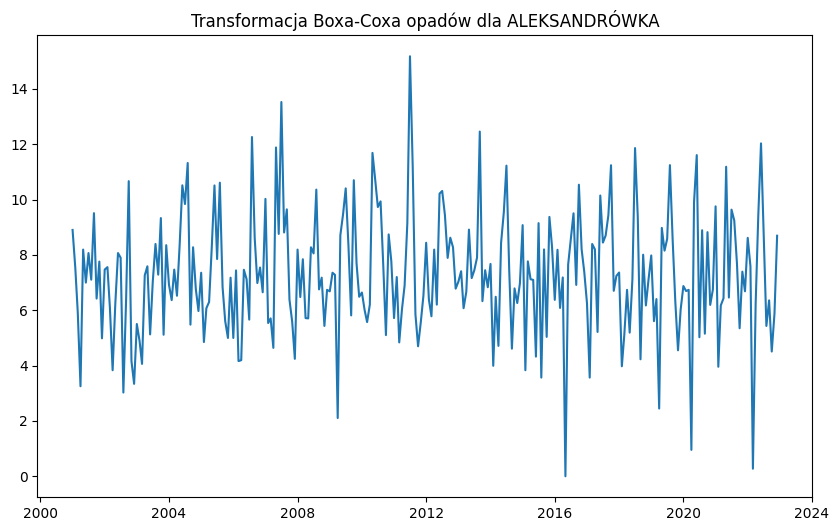

ADF Statistic: -3.118558
p-value: 0.025210
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1202.137, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1143.040, Time=0.17 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1200.142, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1202.536, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1120.039, Time=0.94 sec
 ARIMA(1,0,0)(3,1,0)[12] intercept   : AIC=1115.626, Time=1.81 sec
 ARIMA(1,0,0)(4,1,0)[12] intercept   : AIC=1114.522, Time=2.93 sec
 ARIMA(1,0,0)(5,1,0)[12] intercept   : AIC=1111.066, Time=15.67 sec
 ARIMA(1,0,0)(6,1,0)[12] intercept   : AIC=1103.603, Time=21.92 sec
 ARIMA(1,0,0)(7,1,0)[12] intercept   : AIC=1105.175, Time=34.41 sec
 ARIMA(1,0,0)(6,1,1)[12] intercept   : AIC=1105.223, Time=35.21 sec
 ARIMA(1,0,0)(5,1,1)[12] intercept   : AIC=inf, Time=86.30 sec
 ARIMA(1,0,0)(7,1,1)[12] intercept   : AIC=inf, 

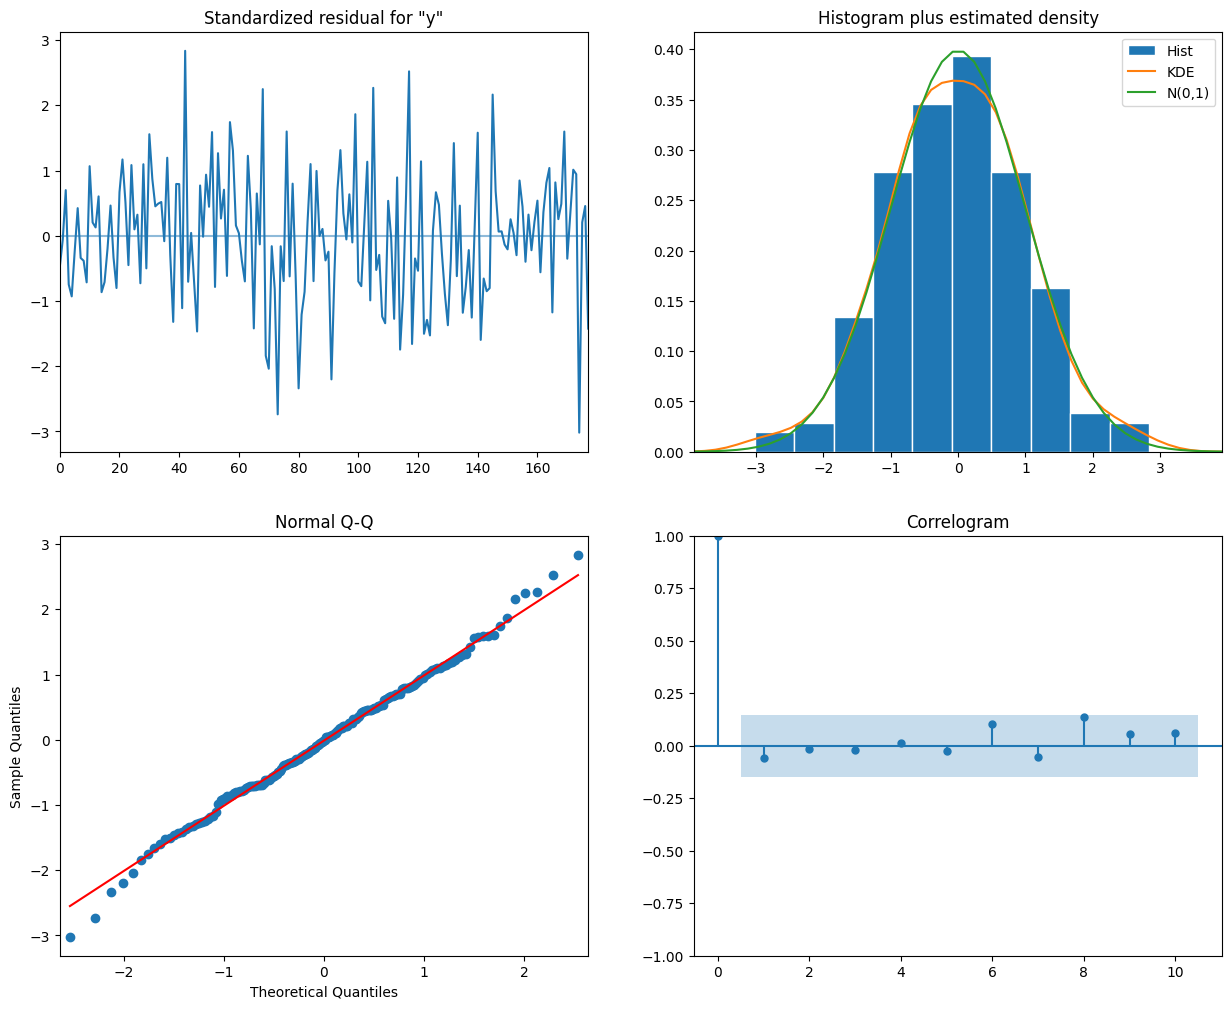

In [2]:
import pandas as pd
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot as plt
from pmdarima import auto_arima
import numpy as np
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# Wczytanie i połączenie danych
abs_dir = 'C:/Users/Acer/Desktop/pulpit/projekt/extracted'
all_files = [os.path.join(abs_dir, file) for file in os.listdir(abs_dir) if file.endswith('.csv')]
df_list = [pd.read_csv(file, encoding='latin', header=None) for file in all_files]
df = pd.concat(df_list, axis=0)

# Przygotowanie danych
df = df.rename(columns={0: "id_stacji", 1: "nazwa_stacji", 2: "rok", 3: "msc", 4: "opad", 8: "opad_max"})
df['data'] = pd.to_datetime(df['rok'].astype(str) + '-' + df['msc'].astype(str))
df.set_index('data', inplace=True)

# Transformacja Boxa-Coxa dla opadu i opadu maksymalnego
df['opad_transformed'], lam_opad = boxcox(df['opad'] + 1)  # Zapewnia, że wszystkie wartości są > 0
df['opad_max_transformed'], lam_opad_max = boxcox(df['opad_max'] + 1)

# Analiza eksploracyjna dla jednej stacji
sample_station = df[df['nazwa_stacji'] == 'ALEKSANDRÓWKA']
plt.figure(figsize=(10, 6))
plt.plot(sample_station.index, sample_station['opad_transformed'])
plt.title('Transformacja Boxa-Coxa opadów dla ALEKSANDRÓWKA')
plt.show()

# Testowanie stacjonarności dla przetransformowanego opadu
result = adfuller(sample_station['opad_transformed'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Dobór modelu SARIMA za pomocą auto_arima z uwzględnieniem opadu maksymalnego jako zmiennej eksogenicznej
exogenous = sample_station[['opad_max_transformed']]  # Zmienne egzogeniczne
model_selection = auto_arima(sample_station['opad_transformed'], exogenous=exogenous,
                             seasonal=True, m=12, stepwise=True,
                             suppress_warnings=True, error_action="ignore", max_order=None,
                             start_p=0, start_q=0, max_p=6, max_q=6, start_P=0, start_Q=0,
                             max_P=10, max_Q=10, d=None, D=1, trace=True, information_criterion='aic')

print(model_selection.summary())

# Przygotowanie danych do walidacji krzyżowej z uwzględnieniem zmiennych egzogenicznych
data = sample_station['opad_transformed'].values
exog = sample_station['opad_max_transformed'].values.reshape(-1, 1)  # Zmienne egzogeniczne jako macierz

# Podział danych na zbiory uczące i testowe
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size

# Inicjalizacja list dla historii, prognoz i obserwacji
history = data[:train_size]
exog_history = exog[:train_size]
predictions = []
actual = data[train_size:]
exog_actual = exog[train_size:]

# Pętla walidacji krzyżowej
for t in range(test_size):
    model = SARIMAX(history, order=model_selection.order, seasonal_order=model_selection.seasonal_order,
                    exog=exog_history, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=0)
    exog_future = exog_actual[t].reshape(1, -1)
    output = model_fit.forecast(exog=exog_future)
    yhat = output[0]
    predictions.append(yhat)
    obs = actual[t]
    history = np.append(history, obs)
    exog_history = np.vstack((exog_history, exog_future))

# Obliczanie RMSE
predictions_inversed = inv_boxcox(predictions, lam_opad) - 1
actual_inversed = inv_boxcox(actual, lam_opad) - 1
mse = mean_squared_error(actual_inversed, predictions_inversed)
rmse = sqrt(mse)
print(f'Test RMSE: {rmse}')

# Wygenerowanie wykresów diagnostycznych dla finalnego modelu
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()


# sample_station = df[df['nazwa_stacji'] == 'WYRZYSK']
# sample_station = df[df['nazwa_stacji'] == 'KRAJENKA']
# sample_station = df[df['nazwa_stacji'] == 'KAMIENNA']
# sample_station = df[df['nazwa_stacji'] == 'ALEKSANDRÓWKA']
# sample_station = df[df['nazwa_stacji'] == 'PRZERWANKI']
# sample_station = df[df['nazwa_stacji'] == 'TOLKMICKO']
# sample_station = df[df['nazwa_stacji'] == 'WEJHEROWO']
# sample_station = df[df['nazwa_stacji'] == 'BACIUTY']
# sample_station = df[df['nazwa_stacji'] == 'PISZ']
# sample_station = df[df['nazwa_stacji'] == 'TOMKOWO']
# sample_station = df[df['nazwa_stacji'] == 'ZBICZNO']
# sample_station = df[df['nazwa_stacji'] == 'STRASZEWO']
# sample_station = df[df['nazwa_stacji'] == 'KOWALEWO']
# sample_station = df[df['nazwa_stacji'] == 'NOWY JASINIEC']
# sample_station = df[df['nazwa_stacji'] == 'RULEWO']
# sample_station = df[df['nazwa_stacji'] == 'KORZENIEWO']
# sample_station = df[df['nazwa_stacji'] == 'SZAMOCIN']
# sample_station = df[df['nazwa_stacji'] == 'CHOSZCZNO']



C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Test RMSE: 15.472444551771954


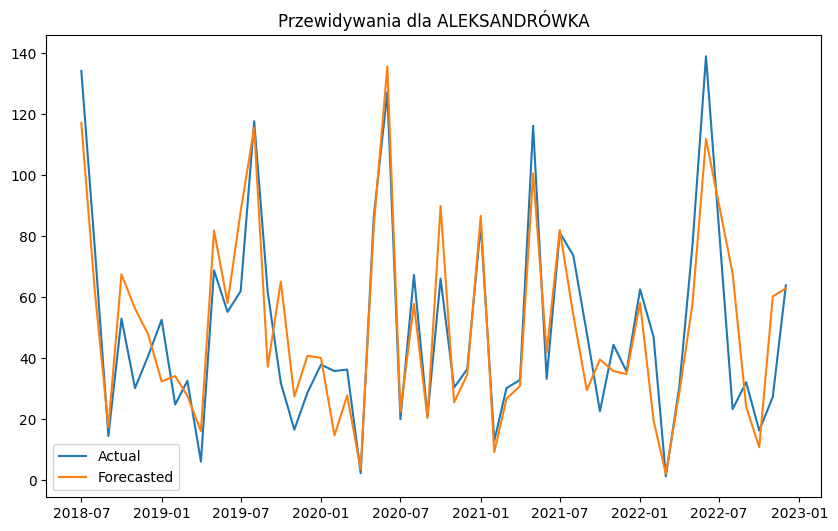

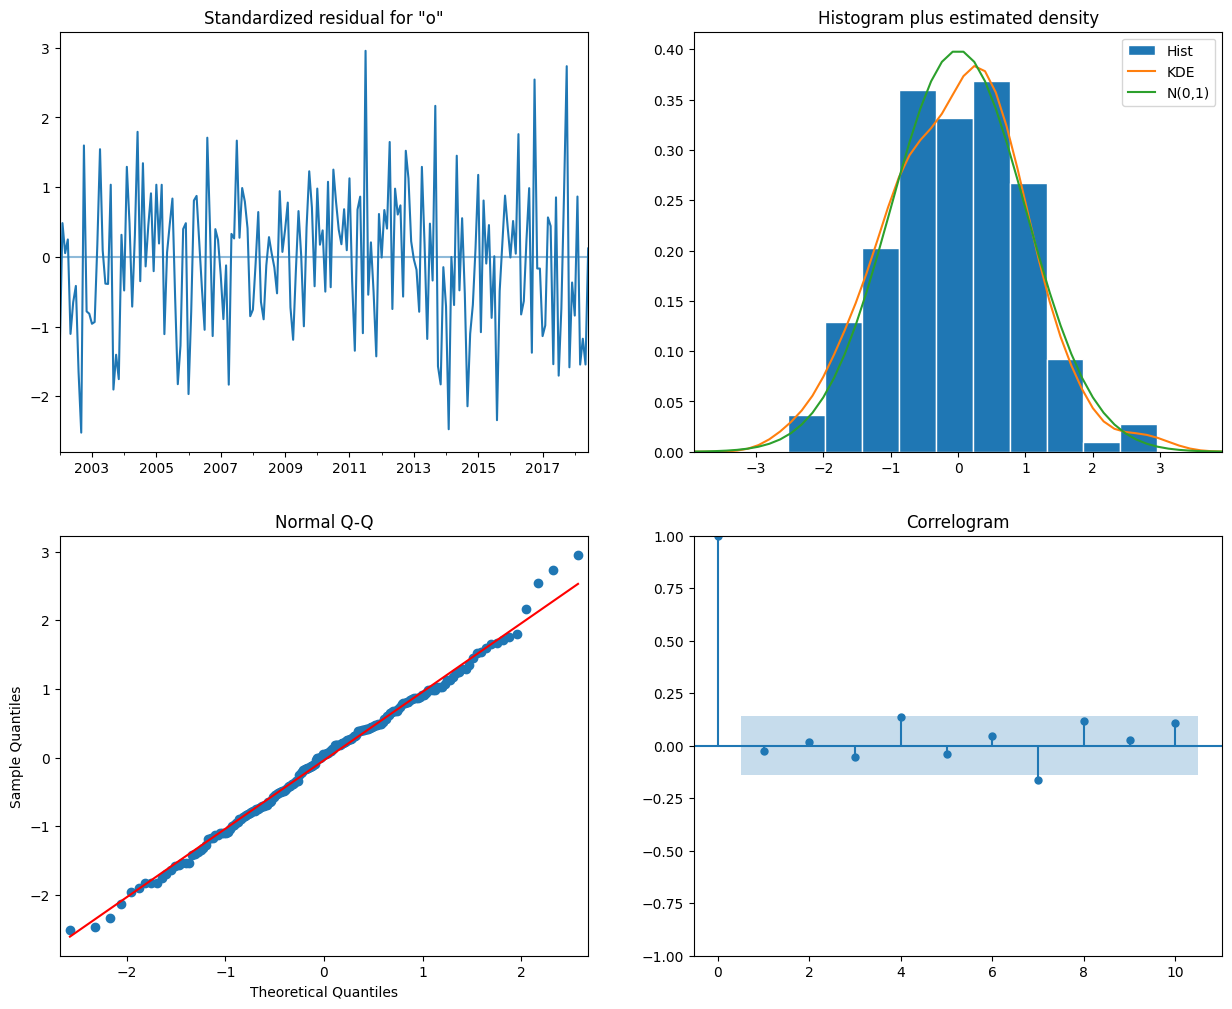

In [4]:
import pandas as pd 
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot as plt
from scipy.stats import boxcox
from scipy.special import inv_boxcox
# Wczytanie i połączenie danych
abs_dir = 'C:/Users/Acer/Desktop/pulpit/projekt/extracted'
all_files = [os.path.join(abs_dir, file) for file in os.listdir(abs_dir) if file.endswith('.csv')]
df_list = [pd.read_csv(file, encoding='latin', header=None) for file in all_files]
df = pd.concat(df_list, axis=0)
# Przygotowanie danych
df = df.rename(columns={0: "id_stacji", 1: "nazwa_stacji", 2: "rok", 3: "msc", 4: "opad", 8: "opad_max"})
df['data'] = pd.to_datetime(df['rok'].astype(str) + '-' + df['msc'].astype(str))
df.set_index('data', inplace=True)
# Dodanie 1 do opadów, aby uniknąć wartości 0 przed transformacją Boxa-Coxa
df['opad'] += 1
df['opad_max'] += 1
# Transformacja Boxa-Coxa
df['opad_transformed'], lam_opad = boxcox(df['opad'])
df['opad_max_transformed'], lam_opad_max = boxcox(df['opad_max'])
# Filtracja danych dla konkretnej stacji - 'BACIUTY'
sample_station = df[df['nazwa_stacji'] == 'BACIUTY']
# Podział danych na zbiory uczące i testowe
data = sample_station['opad_transformed']
exog = sample_station[['opad_max_transformed']].values
n = len(data)
train = data[:int(n*0.8)]
test = data[int(n*0.8):]
exog_train = exog[:int(n*0.8), :]
exog_test = exog[int(n*0.8):, :]
# Dopasowanie modelu SARIMAX z ustalonymi parametrami
model = SARIMAX(train, order=(0,0,0), seasonal_order=(6,1,0,12), exog=exog_train)
model_fit = model.fit(disp=False)
# Prognozowanie
predictions = model_fit.forecast(steps=len(test), exog=exog_test)
# Przekształcenie predykcji z powrotem
predictions_inversed = inv_boxcox(predictions, lam_opad)
# Ocena modelu
test_inversed = inv_boxcox(test, lam_opad)
mse = mean_squared_error(test_inversed, predictions_inversed)
rmse = sqrt(mse)
print(f'Test RMSE: {rmse}')
# Wykres
plt.figure(figsize=(10,6))
plt.plot(test.index, test_inversed, label='Actual')
plt.plot(test.index, predictions_inversed, label='Forecasted')
plt.title('Przewidywania dla BACIUTY')
plt.legend()
plt.show()
# Wygenerowanie wykresów diagnostycznych dla finalnego modelu
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()


C:\Users\Acer\AppData\Local\Temp\ipykernel_20260\458653882.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_station['opad_transformed'], lam_opad = boxcox(sample_station['opad'])
C:\Users\Acer\AppData\Local\Temp\ipykernel_20260\458653882.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_station['opad_max_transformed'], lam_opad_max = boxcox(sample_station['opad_max'])
C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python

Test RMSE: 41.02160741310892


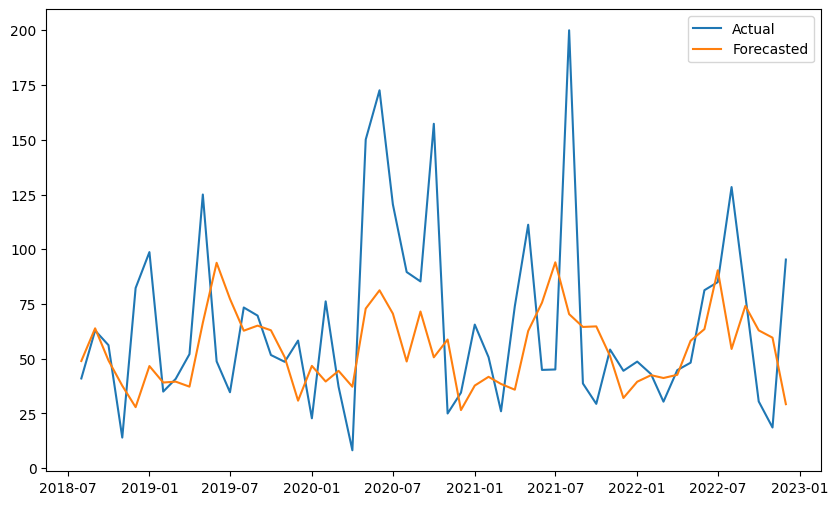

In [4]:
import os
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# Wczytanie i przygotowanie danych
abs_dir = 'C:/Users/Acer/Desktop/pulpit/projekt/extracted'
all_files = [os.path.join(abs_dir, file) for file in os.listdir(abs_dir) if file.endswith('.csv')]
df_list = [pd.read_csv(file, encoding='latin', header=None) for file in all_files]
df = pd.concat(df_list, axis=0)

# Przygotowanie danych
df = df.rename(columns={0: "id_stacji", 1: "nazwa_stacji", 2: "rok", 3: "msc", 4: "opad", 8: "opad_max"})
df['data'] = pd.to_datetime(df['rok'].astype(str) + '-' + df['msc'].astype(str), errors='coerce')
df.set_index('data', inplace=True)

# Filtracja danych dla konkretnej stacji - 'WARSZOWICE'
sample_station = df[df['nazwa_stacji'] == 'WARSZOWICE']

# Dodanie 1 do opadów, aby uniknąć wartości 0 przed transformacją Boxa-Coxa
sample_station.loc[:, 'opad'] += 1
sample_station.loc[:, 'opad_max'] += 1

# Transformacja Boxa-Coxa
sample_station['opad_transformed'], lam_opad = boxcox(sample_station['opad'])
sample_station['opad_max_transformed'], lam_opad_max = boxcox(sample_station['opad_max'])

# Podział danych na zbiory uczące i testowe
data = sample_station['opad_transformed']
n = len(data)
train = data[:int(n*0.8)]
test = data[int(n*0.8):]

# Dopasowanie modelu SARIMAX
model = SARIMAX(train, order=(0,0,0), seasonal_order=(6,1,0,12))
model_fit = model.fit(disp=False)

# Prognozowanie
predictions = model_fit.forecast(steps=len(test))

# Przekształcenie predykcji z powrotem
predictions_inversed = inv_boxcox(predictions, lam_opad)

# Ocena modelu
test_inversed = inv_boxcox(test, lam_opad)
mse = mean_squared_error(test_inversed, predictions_inversed)
rmse = sqrt(mse)
print(f'Test RMSE: {rmse}')

# Wykres
plt.figure(figsize=(10,6))
plt.plot(test.index, test_inversed, label='Actual')
plt.plot(test.index, predictions_inversed, label='Forecasted')
plt.legend()
plt.show()


C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Acer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r

Test RMSE: 41.66458472526046


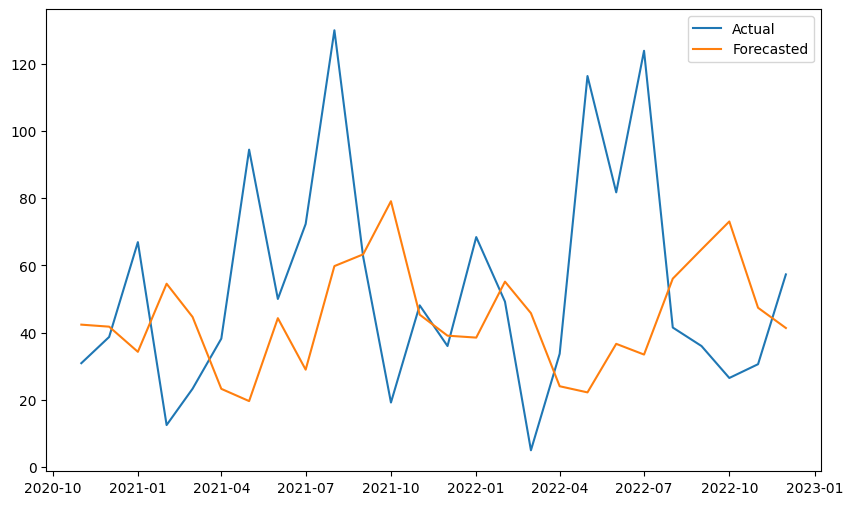

In [2]:
import os
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox, zscore
from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# Wczytanie i przygotowanie danych
abs_dir = 'C:/Users/Acer/Desktop/pulpit/projekt/extracted'
all_files = [os.path.join(abs_dir, file) for file in os.listdir(abs_dir) if file.endswith('.csv')]
df_list = [pd.read_csv(file, encoding='latin', header=None) for file in all_files]
df = pd.concat(df_list, axis=0)

# Przygotowanie danych
df = df.rename(columns={0: "id_stacji", 1: "nazwa_stacji", 2: "rok", 3: "msc", 4: "opad", 8: "opad_max"})
df['data'] = pd.to_datetime(df['rok'].astype(str) + '-' + df['msc'].astype(str), errors='coerce')
df.set_index('data', inplace=True)

# Filtracja danych dla konkretnej stacji - 'SEJNY'
sample_station = df[df['nazwa_stacji'] == 'SEJNY'].copy()

# Dodanie 1 do opadów, aby uniknąć wartości 0 przed transformacją Boxa-Coxa
sample_station.loc[:, 'opad'] += 1
sample_station.loc[:, 'opad_max'] += 1

# Wykrywanie i usuwanie wartości odstających
z_scores = np.abs(zscore(sample_station[['opad', 'opad_max']]))
filter = (z_scores < 3).all(axis=1)
sample_station = sample_station[filter]

# Transformacja Boxa-Coxa
sample_station['opad_transformed'], lam_opad = boxcox(sample_station['opad'])
sample_station['opad_max_transformed'], lam_opad_max = boxcox(sample_station['opad_max'])

# Podział danych na zbiory uczące i testowe
data = sample_station['opad_transformed']
n = len(data)
train = data[:int(n*0.8)]
test = data[int(n*0.8):]

# Dopasowanie modelu SARIMAX
model = SARIMAX(train, order=(0,0,0), seasonal_order=(6,1,0,12))
model_fit = model.fit(disp=False)

# Prognozowanie
predictions = model_fit.forecast(steps=len(test))

# Przekształcenie predykcji z powrotem
predictions_inversed = inv_boxcox(predictions, lam_opad)

# Ocena modelu
test_inversed = inv_boxcox(test, lam_opad)
mse = mean_squared_error(test_inversed, predictions_inversed)
rmse = sqrt(mse)
print(f'Test RMSE: {rmse}')

# Wykres
plt.figure(figsize=(10,6))
plt.plot(test.index, test_inversed, label='Actual')
plt.plot(test.index, predictions_inversed, label='Forecasted')
plt.legend()
plt.show()
